In [3]:
from scipy import stats

In [ ]:
# cbar = fig.colorbar(graph, shrink=0.4)
# cbar.minorticks_on()
# cbar.ax.tick_params(axis='y', labelsize=20)
# cbar.set_label('Display range: 3.13-23.12 in degrees Celcius',fontsize=18)

# #setting the gridlines and axis labels using cartopy(not matplotlib , to get the correct labels)
# gl=ax.gridlines(draw_labels=True, alpha=0.6 , color='purple')
# gl.xlabel_style={'size':28}
# gl.ylabel_style={'size':28}

In [4]:
spatial_data = xr.open_dataset('india.timmean.nc').squeeze()
spatial_data


<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 35, lon: 32)
Coordinates:
    time       datetime64[ns] 1932-06-12
  * lon        (lon) float64 60.62 61.88 63.12 64.38 ... 95.62 96.88 98.12 99.38
  * lat        (lat) float64 5.5 6.5 7.5 8.5 9.5 ... 35.5 36.5 37.5 38.5 39.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (bnds) datetime64[ns] ...
    gsletccdi  (lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Apr 21 05:40:42 2023: cdo timmean india.his.nc india.ti...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

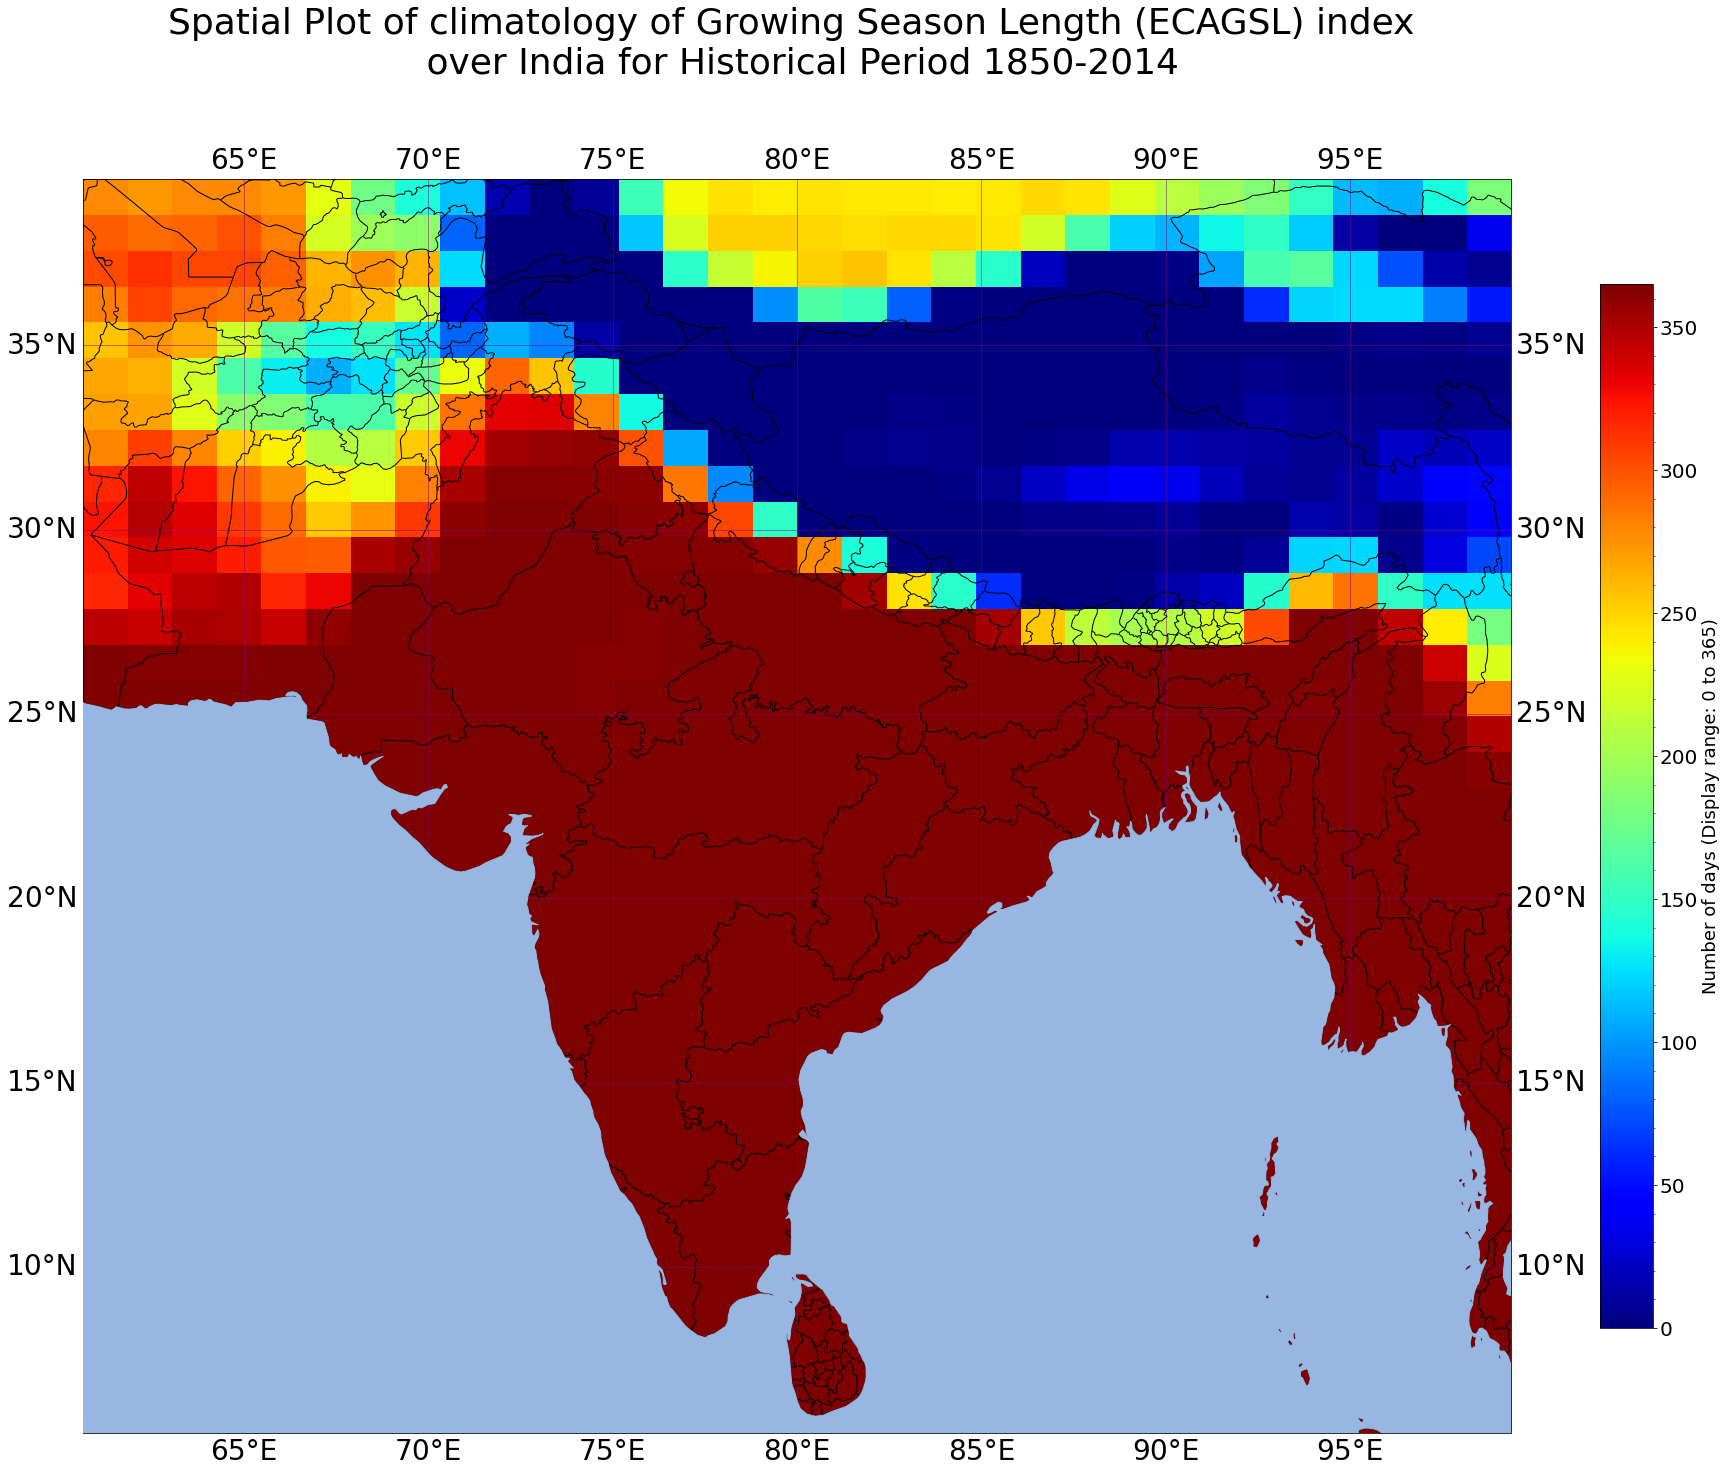

In [13]:
## climatology spatial plot 

# importing the important libraries 

import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# reading the data

spatial_data = xr.open_dataset('india.timmean.nc').squeeze()
spatial_data = spatial_data['gsletccdi']
# Convert timedelta64[ns] to the number of days (float)
# spatial_data = spatial_data.astype('timedelta64[D]').astype(float)

# spatial_data = spatial_data.mean(dim='time')

# plotting the data
lat = spatial_data.lat
lon = spatial_data.lon

fig = plt.figure(figsize = (32,32))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree(central_longitude=0.0, globe = None))

mp = ax.imshow(spatial_data, extent=(lon.min(), lon.max(), lat.min(), lat.max()), cmap = 'jet', origin='lower')
plt.title('Spatial Plot of climatology of Growing Season Length (ECAGSL) index \n over India for Historical Period 1850-2014', fontsize = 36, y=1.08)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')
ax.add_feature(cfeature.BORDERS,edgecolor='black')
ax.add_feature(states_provinces, edgecolor='black')

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN,zorder=100)


cbar = fig.colorbar(mp, shrink=0.6)
cbar.minorticks_on()
cbar.ax.tick_params(axis='y', labelsize=20)
cbar.set_label('Number of days (Display range: 0 to 365)',fontsize=18)
# func = lambda x,pos: "{:g}".format(x/3.154e16)
# fmt = plt.ticker.FuncFormatter(func)

# plt.colorbar(..., format=fmt)

# mp.set_clim(0,365)
#setting the gridlines and axis labels using cartopy(not matplotlib , to get the correct labels)
gl=ax.gridlines(draw_labels=True, alpha=0.6 , color='purple')
gl.xlabel_style={'size':28}
gl.ylabel_style={'size':28}

plt.show()

<ipython-input-14-9f5845ef7edf>:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx10p = nc.variables['gslETCCDI'][:]
<ipython-input-14-9f5845ef7edf>:40: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat = nc.variables['lat'][:]
<ipython-input-14-9f5845ef7edf>:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silen

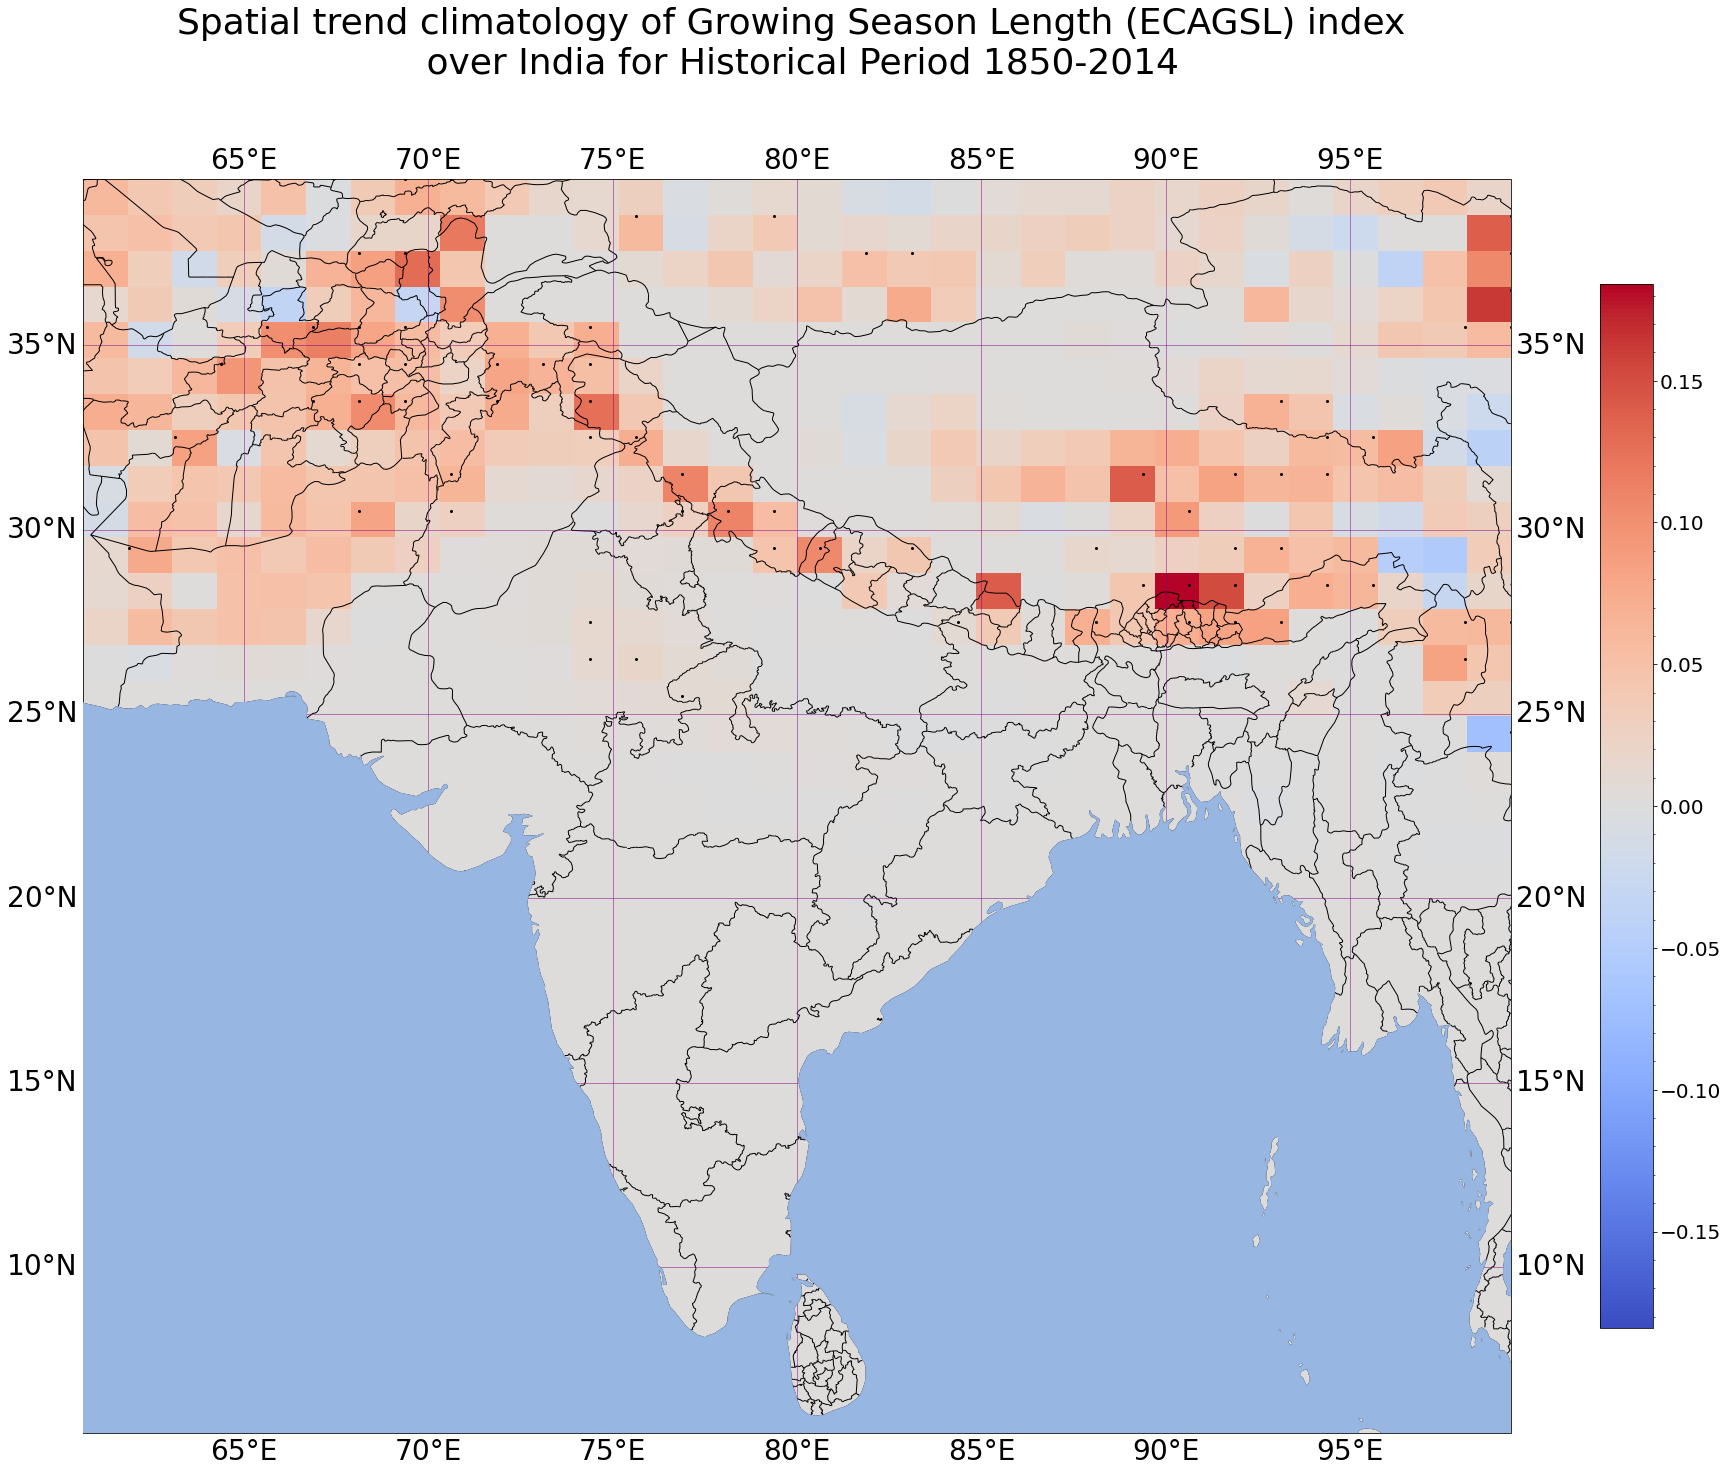

In [14]:
## spatial trend 
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm
import netCDF4

nc = netCDF4.Dataset('gsl.india.historical.nc')

# extract the dataset for cwdETCCDI

tx10p = nc.variables['gslETCCDI'][:] 

# dimensions of the data
time_dim,lat_dim,lon_dim = tx10p.shape

# arrays to store the trend and p-values
trend = np.zeros((lat_dim,lon_dim))
p_values = np.zeros((lat_dim,lon_dim))

# loop over each grid point 

for lat_idx in range(lat_dim):
    for lon_idx in range(lon_dim):
        
        # calculate data at each grid point
        data = tx10p[:,lat_idx,lon_idx]
        
        # fit a linear regression model to the data
        slope,intercept,r_value,p_value,std_error = stats.linregress(np.arange(time_dim),data)
        
        # append the slope (trend) and p-values in the arrays
        trend[lat_idx,lon_idx] = slope
        p_values[lat_idx,lon_idx] = p_value
        
# visualising the trend using a heatmap or contour 

lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]

significant_trends = p_values < 0.05

# Normalize the colorbar
max_abs_value = np.max(np.abs(trend))
norm = TwoSlopeNorm(vmin=-max_abs_value, vcenter=0, vmax=max_abs_value)


fig = plt.figure(figsize=(32, 32))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=0.0, globe=None))


mp = ax.imshow(trend, extent=(lon.min(), lon.max(), lat.min(), lat.max()), cmap='coolwarm', origin='lower', norm=norm)


# # Plot black dots at significant trend locations
for lat_idx in range(lat_dim):
    for lon_idx in range(lon_dim):
        if significant_trends[lat_idx, lon_idx]:
            ax.plot(lon[lon_idx], lat[lat_idx], 'ko', markersize=2, transform=ccrs.PlateCarree())

plt.title('Spatial trend climatology of Growing Season Length (ECAGSL) index \n over India for Historical Period 1850-2014', fontsize=36, y=1.08)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')
ax.add_feature(cfeature.BORDERS,edgecolor='black')
ax.add_feature(states_provinces, edgecolor='black')

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN, zorder = 100)



cbar = fig.colorbar(mp, shrink=0.6)
cbar.minorticks_on()
cbar.ax.tick_params(axis='y', labelsize=20)
# cbar.set_label('Number of days (Display range: 0 to 365)',fontsize=18)

#setting the gridlines and axis labels using cartopy(not matplotlib , to get the correct labels)
gl=ax.gridlines(draw_labels=True, alpha=0.6 , color='purple')
gl.xlabel_style={'size':28}
gl.ylabel_style={'size':28}

# plt.savefig('historical-spatial-climatology.png', dpi=1200, bbox_inches='tight')
plt.show()

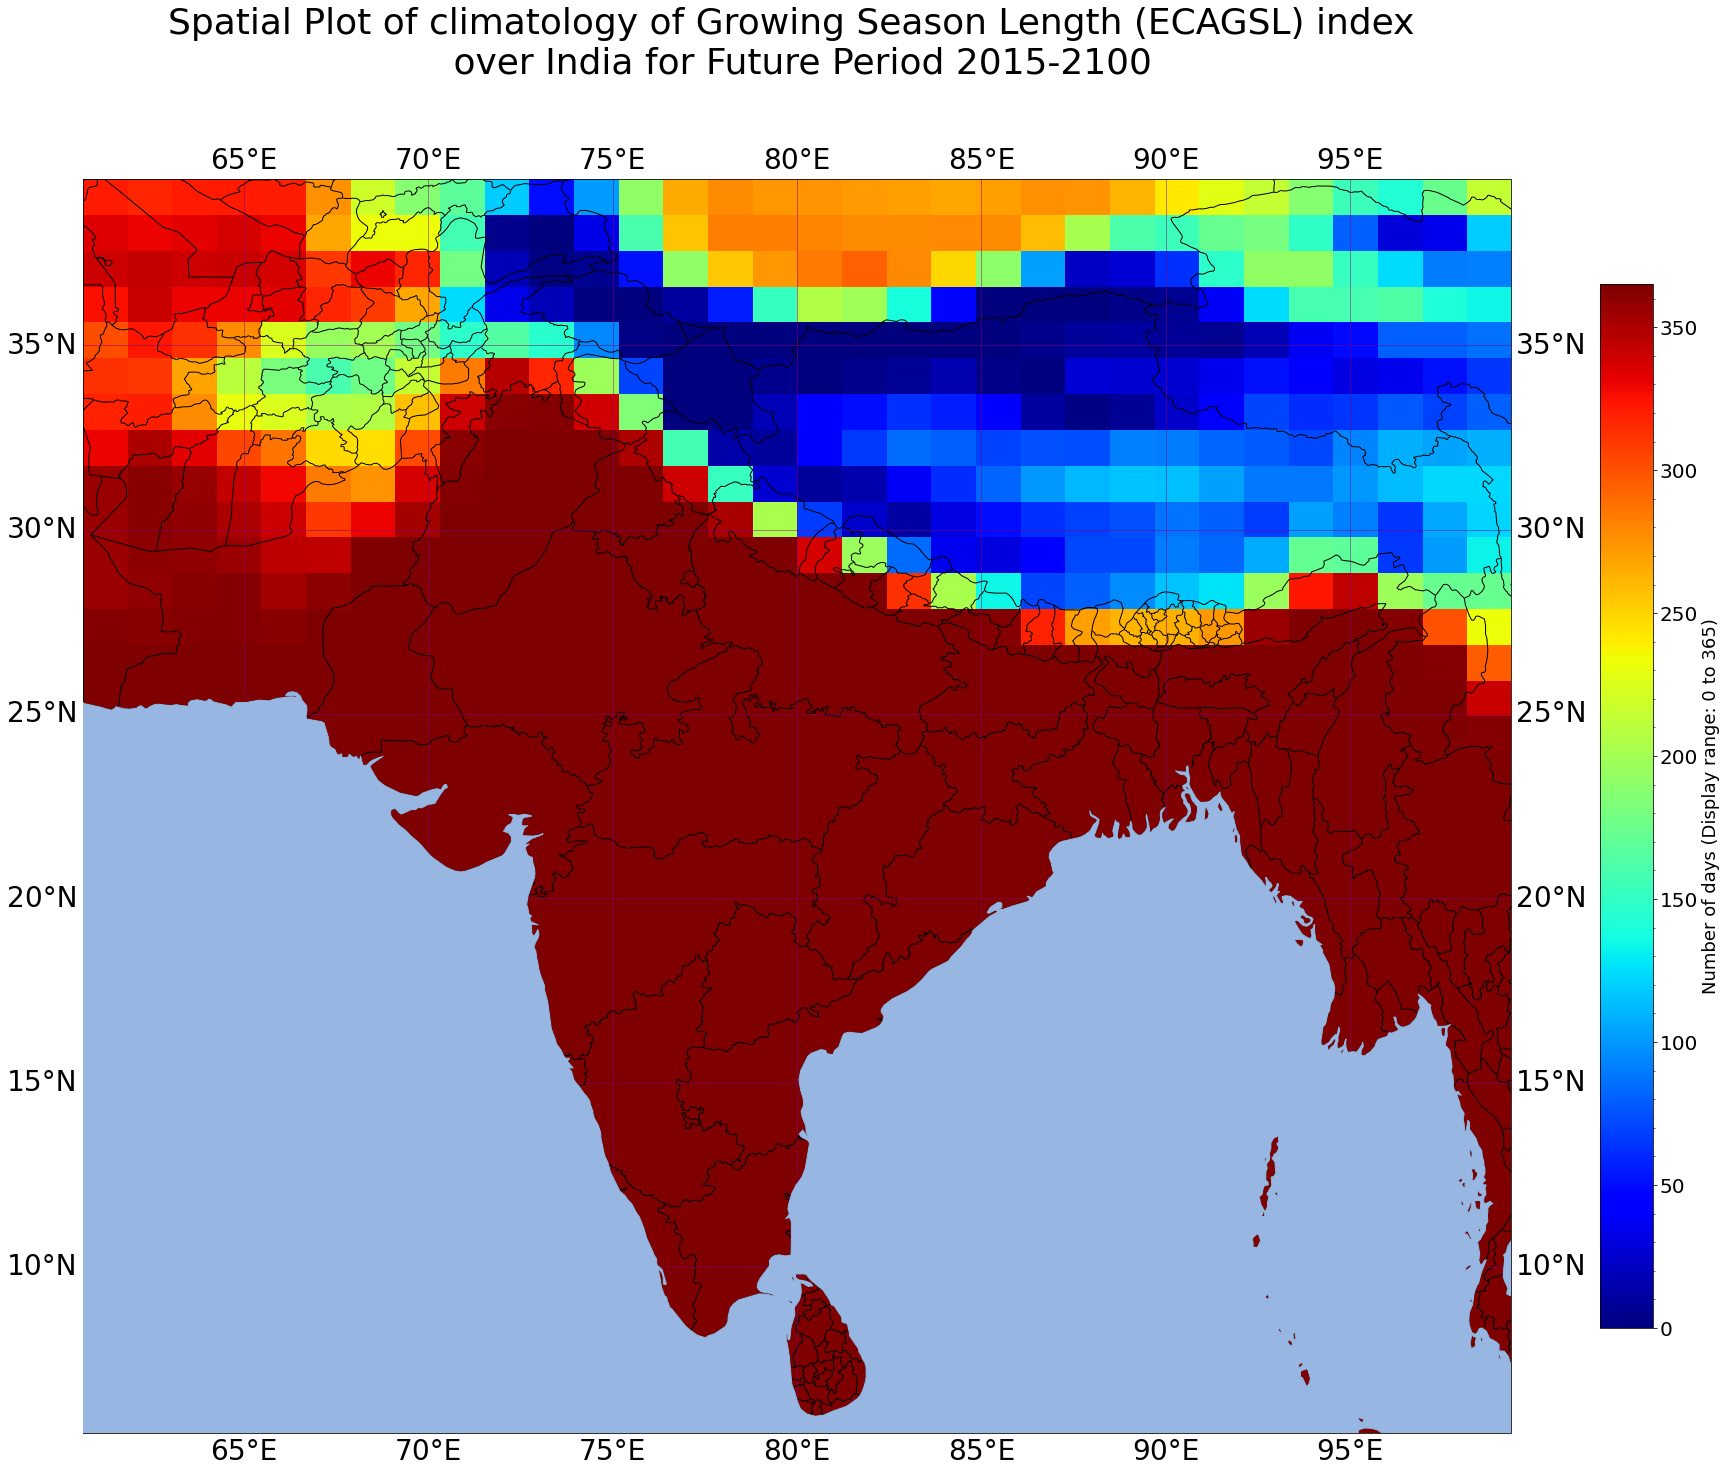

In [17]:
## climatology spatial plot 

# importing the important libraries 

import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# reading the data

spatial_data = xr.open_dataset('india.tim.fut.nc').squeeze()
spatial_data = spatial_data['gsletccdi']
# Convert timedelta64[ns] to the number of days (float)
# spatial_data = spatial_data.astype('timedelta64[D]').astype(float)

# spatial_data = spatial_data.mean(dim='time')

# plotting the data
lat = spatial_data.lat
lon = spatial_data.lon

fig = plt.figure(figsize = (32,32))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree(central_longitude=0.0, globe = None))

mp = ax.imshow(spatial_data, extent=(lon.min(), lon.max(), lat.min(), lat.max()), cmap = 'jet', origin='lower')
plt.title('Spatial Plot of climatology of Growing Season Length (ECAGSL) index \n over India for Future Period 2015-2100', fontsize = 36, y=1.08)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')
ax.add_feature(cfeature.BORDERS,edgecolor='black')
ax.add_feature(states_provinces, edgecolor='black')

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN,zorder=100)


cbar = fig.colorbar(mp, shrink=0.6)
cbar.minorticks_on()
cbar.ax.tick_params(axis='y', labelsize=20)
cbar.set_label('Number of days (Display range: 0 to 365)',fontsize=18)
# func = lambda x,pos: "{:g}".format(x/3.154e16)
# fmt = plt.ticker.FuncFormatter(func)

# plt.colorbar(..., format=fmt)

# mp.set_clim(0,365)
#setting the gridlines and axis labels using cartopy(not matplotlib , to get the correct labels)
gl=ax.gridlines(draw_labels=True, alpha=0.6 , color='purple')
gl.xlabel_style={'size':28}
gl.ylabel_style={'size':28}

plt.show()

<ipython-input-18-97c96381a358>:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tx10p = nc.variables['gslETCCDI'][:]
<ipython-input-18-97c96381a358>:40: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat = nc.variables['lat'][:]
<ipython-input-18-97c96381a358>:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silen

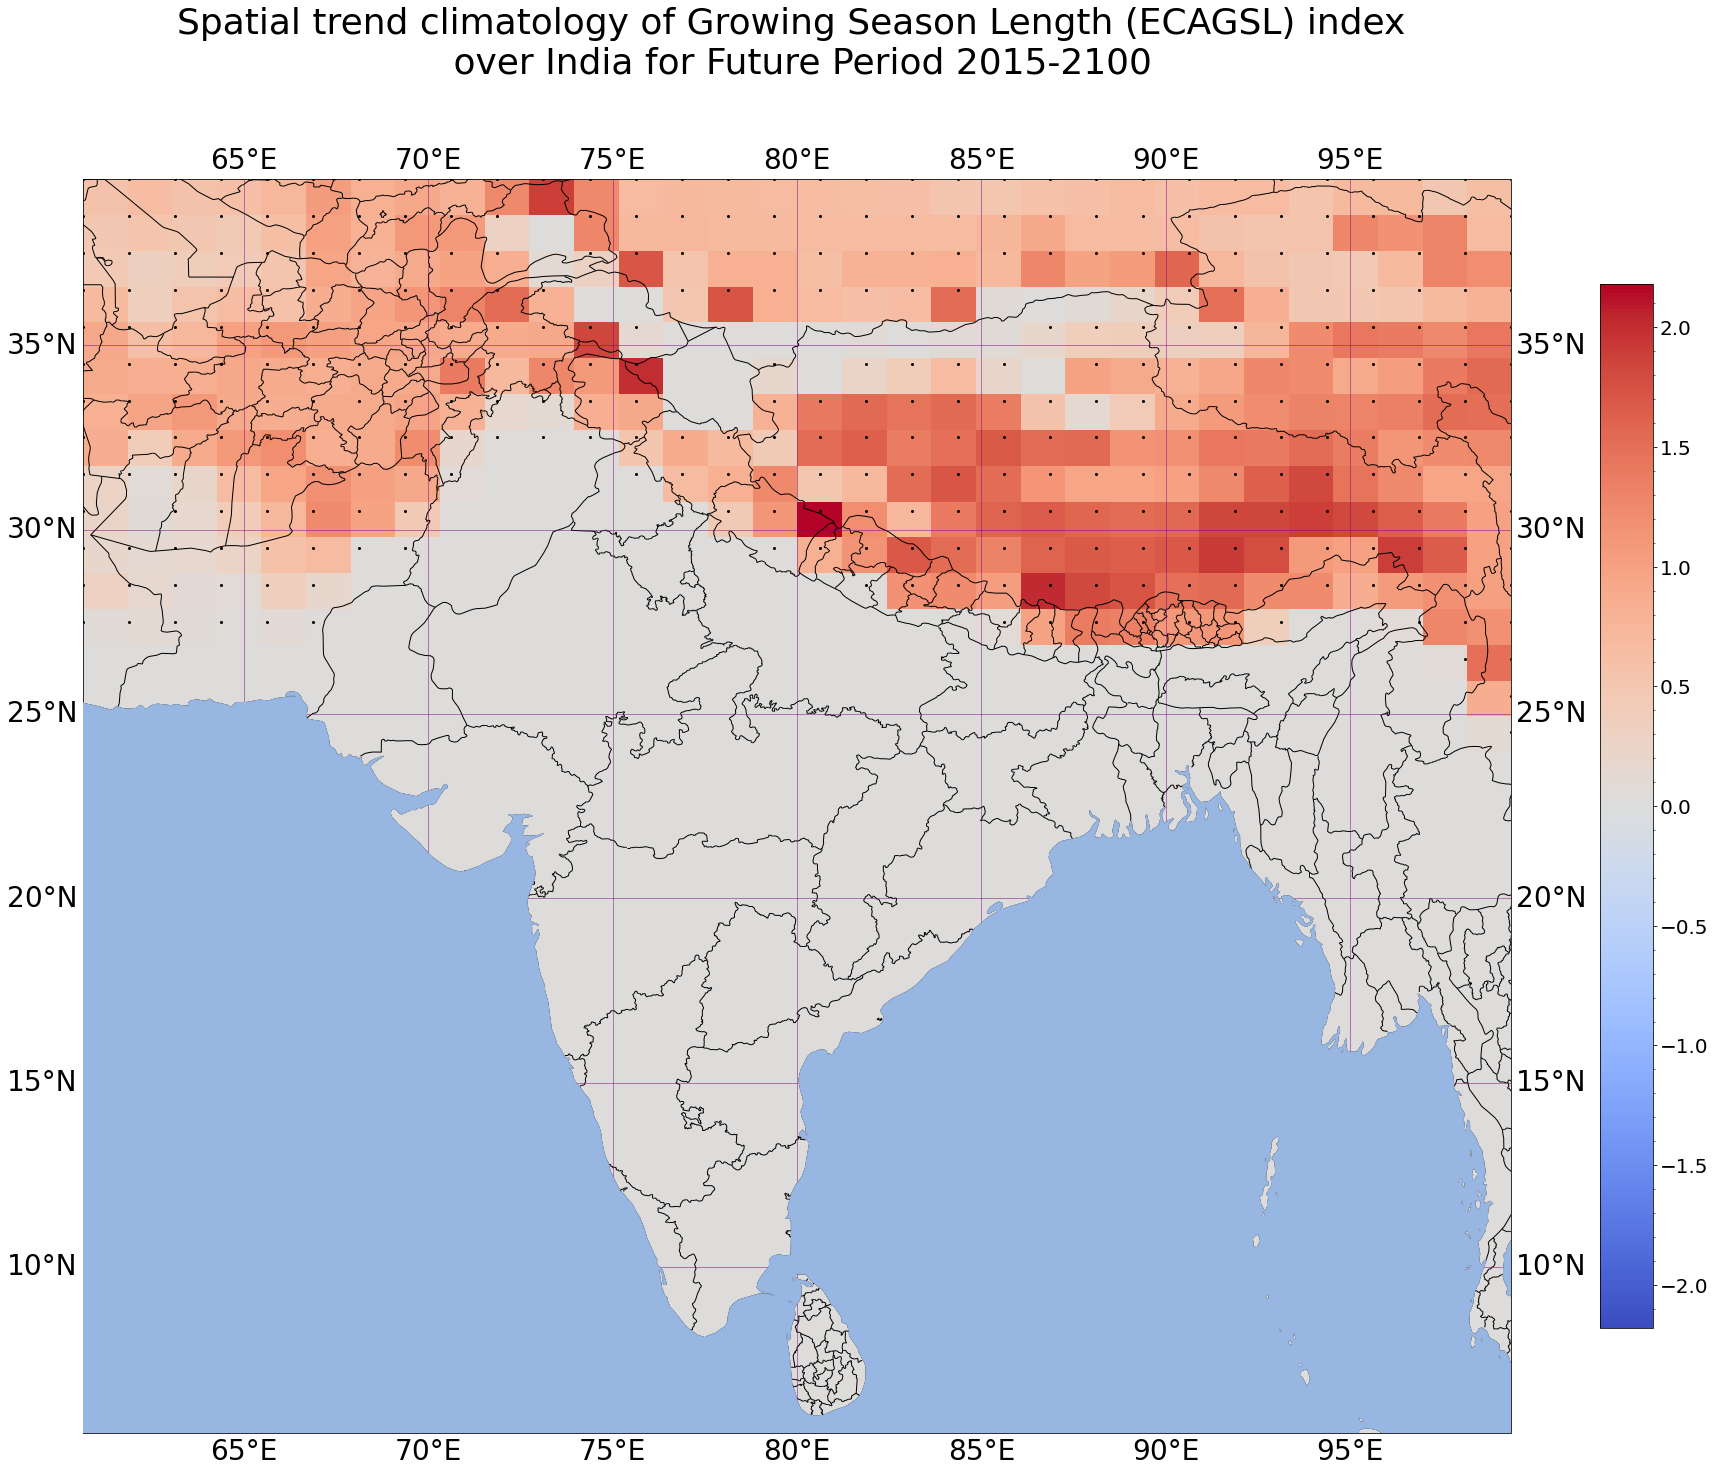

In [18]:
## spatial trend 
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm
import netCDF4

nc = netCDF4.Dataset('gsl.india.future.nc')

# extract the dataset for cwdETCCDI

tx10p = nc.variables['gslETCCDI'][:] 

# dimensions of the data
time_dim,lat_dim,lon_dim = tx10p.shape

# arrays to store the trend and p-values
trend = np.zeros((lat_dim,lon_dim))
p_values = np.zeros((lat_dim,lon_dim))

# loop over each grid point 

for lat_idx in range(lat_dim):
    for lon_idx in range(lon_dim):
        
        # calculate data at each grid point
        data = tx10p[:,lat_idx,lon_idx]
        
        # fit a linear regression model to the data
        slope,intercept,r_value,p_value,std_error = stats.linregress(np.arange(time_dim),data)
        
        # append the slope (trend) and p-values in the arrays
        trend[lat_idx,lon_idx] = slope
        p_values[lat_idx,lon_idx] = p_value
        
# visualising the trend using a heatmap or contour 

lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]

significant_trends = p_values < 0.05

# Normalize the colorbar
max_abs_value = np.max(np.abs(trend))
norm = TwoSlopeNorm(vmin=-max_abs_value, vcenter=0, vmax=max_abs_value)


fig = plt.figure(figsize=(32, 32))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=0.0, globe=None))


mp = ax.imshow(trend, extent=(lon.min(), lon.max(), lat.min(), lat.max()), cmap='coolwarm', origin='lower', norm=norm)


# # Plot black dots at significant trend locations
for lat_idx in range(lat_dim):
    for lon_idx in range(lon_dim):
        if significant_trends[lat_idx, lon_idx]:
            ax.plot(lon[lon_idx], lat[lat_idx], 'ko', markersize=2, transform=ccrs.PlateCarree())

plt.title('Spatial trend climatology of Growing Season Length (ECAGSL) index \n over India for Future Period 2015-2100', fontsize=36, y=1.08)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')
ax.add_feature(cfeature.BORDERS,edgecolor='black')
ax.add_feature(states_provinces, edgecolor='black')

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN, zorder = 100)



cbar = fig.colorbar(mp, shrink=0.6)
cbar.minorticks_on()
cbar.ax.tick_params(axis='y', labelsize=20)
# cbar.set_label('Number of days (Display range: 0 to 365)',fontsize=18)

#setting the gridlines and axis labels using cartopy(not matplotlib , to get the correct labels)
gl=ax.gridlines(draw_labels=True, alpha=0.6 , color='purple')
gl.xlabel_style={'size':28}
gl.ylabel_style={'size':28}

# plt.savefig('historical-spatial-climatology.png', dpi=1200, bbox_inches='tight')
plt.show()